### Load data and Preprocess

**Import dependencies**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from scipy import stats
import matplotlib.colors as mcolors
colors = ['#FFC07F', # Arena A -> Task 1 (intensity  or duration)
          '#94c47d', #  Arena B -> Task 2 (click rate or sweep rate)
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

**load data**

In [4]:
# Val to change depending on task
# NEW TASK SETUP
data_path = "data/ALL_6.20.25.csv"
test_tag = 900263000259957

task1_label = "Intensity" # task ID = 24, Intensity or Duration
task2_label = "ClickRate" # task ID = 29, ClickRate or SweepRate

In [7]:
ALL = pd.read_csv(data_path).iloc[:,1:]
ALL = ALL.dropna()
ALL['times'] = pd.to_datetime(ALL['times'],format='%Y-%m-%d %H:%M:%S.%f',)             # any bad rows become NaT
ALL['day'] = ALL['times'].dt.normalize()   # midnight of each day
all_days = ALL["day"].dt.date.unique()

subject_IDs = np.sort(ALL.subjects.unique())
subject_IDs  = subject_IDs[subject_IDs != test_tag]

# find the two tasks
Task1_df = ALL[ALL.task == 24].reset_index(drop=True)
Task2_df = ALL[ALL.task == 29].reset_index(drop=True)

if task1_label != "Intensity":
    Task2_df.drop(Task2_df[Task2_df["specific_stims"] == "clicks_32hz_1s_60db.wav"].index, inplace=True) 
else:
    Task2_df = Task2_df[500:]

ALL = pd.concat([Task1_df, Task2_df]).reset_index(drop=True)

**sanity check if the two rules are correct in the filtered data**

In [8]:
# should have only two unique stimuli for each actioni in each rule
T1_right = Task1_df.loc[
    Task1_df['trial_types'] == 1, 
    'specific_stims'
].unique()
T1_left = Task1_df.loc[
    Task1_df['trial_types'] == 0, 
    'specific_stims'
].unique()
print(T1_right)
print(T1_left)

T2_right = Task2_df.loc[
    Task2_df['trial_types'] == 1, 
    'specific_stims'
].unique()
T2_left = Task2_df.loc[
    Task2_df['trial_types'] == 0, 
    'specific_stims'
].unique()
print(T2_right)
print(T2_left)

['clicks_12hz_1s_60db.wav' 'clicks_32hz_1s_60db.wav']
['clicks_12hz_1s_70db.wav' 'clicks_32hz_1s_70db.wav']
['clicks_12hz_1s_60db.wav' 'clicks_12hz_1s_70db.wav']
['clicks_32hz_1s_70db.wav' 'clicks_32hz_1s_60db.wav']


In [9]:
# 192.168.0.24: duration context (new task)
# 192.168.0.29: sweep direction (new task)
# trial = 1 is LEFT

# ---------------------------- Old task ----------------------------------------------- #
#                      I LOW 60 (LEFT 24)           I HIGHT 70 (RIGHT 23)        
# CR LOW 12 (LEFT 24)     (context-invariant)       (context-dependent)
# CR HIGH 32 (RIGHT 23)     (context-dependent)       (context-invariant)  

# the invariant stimuli are: 'clicks_12hz_1s_60db.wav', 'clicks_32hz_1s_70db.wav'
# the context-dependent stimuli are: 'clicks_12hz_1s_70db.wav', 'clicks_32hz_1s_60db.wav' 

# ---------------------------- New task ----------------------------------------------- #
#                      Duration short 50ms (LEFT 24)    Duration long 100ms (RIGHT 23)        
# SD neg -40 (LEFT 24)     (context-invariant)            (context-dependent)
# SR pos +40 (RIGHT 23)     (context-dependent)             (context-invariant)  

# the invariant stimuli are: 'fm_50ms_-40octs.wav', 'fm_100ms_+40octs.wav'
# the context-dependent stimuli are: 'fm_50ms_+40octs.wav', 'fm_100ms_-40octs.wav' 

In [10]:
# load context-dependent and invariant trials for each task
if task1_label != "Intensity":
    INVARIANT_TASK1 = Task1_df[
        (Task1_df['specific_stims'] == 'fm_50ms_-40octs.wav')
        | 
        (Task1_df['specific_stims'] == 'fm_100ms_+40octs.wav')
    ]
    DEPENDENT_TASK1 = Task1_df[
        (Task1_df['specific_stims'] == 'fm_50ms_+40octs.wav')
        | 
        (Task1_df['specific_stims'] == 'fm_100ms_-40octs.wav')
    ]

    INVARIANT_TASK2 = Task2_df[
        (Task2_df['specific_stims'] == 'fm_50ms_-40octs.wav')
        | 
        (Task2_df['specific_stims'] == 'fm_100ms_+40octs.wav')
    ]
    DEPENDENT_TASK2 = Task2_df[
        (Task2_df['specific_stims'] == 'fm_50ms_+40octs.wav')
        | 
        (Task2_df['specific_stims'] == 'fm_100ms_-40octs.wav')
    ]
else: 
    INVARIANT_TASK1 = Task1_df[
    (Task1_df['specific_stims'] == 'clicks_12hz_1s_60db.wav')
    | 
    (Task1_df['specific_stims'] == 'clicks_32hz_1s_70db.wav')
    ]
    DEPENDENT_TASK1 = Task1_df[
        (Task1_df['specific_stims'] == 'clicks_12hz_1s_70db.wav')
        | 
        (Task1_df['specific_stims'] == 'clicks_32hz_1s_60db.wav')
    ]

    INVARIANT_TASK2 = Task2_df[
        (Task2_df['specific_stims'] == 'clicks_12hz_1s_60db.wav')
        | 
        (Task2_df['specific_stims'] == 'clicks_32hz_1s_70db.wav')
    ]
    DEPENDENT_TASK2 = Task2_df[
        (Task2_df['specific_stims'] == 'clicks_12hz_1s_70db.wav')
        | 
        (Task2_df['specific_stims'] == 'clicks_32hz_1s_60db.wav')
    ]

### plot the overall performance in both tasks

**plot performance over trials**

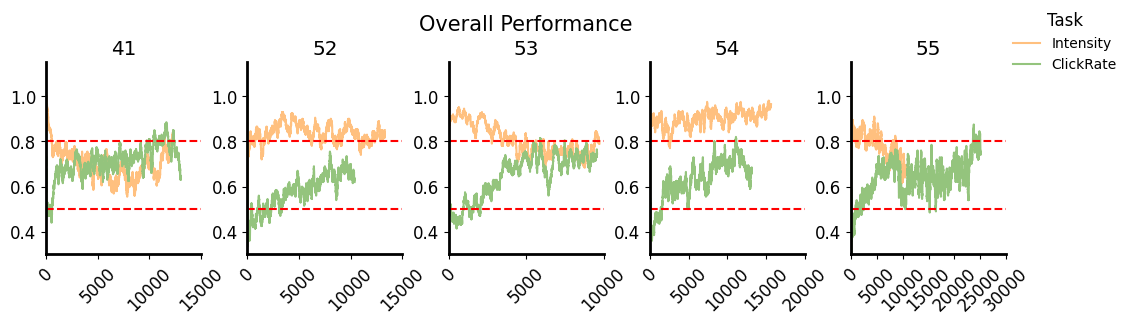

In [11]:
fig = plt.figure(figsize=(12, 6))
roll_size = 200
import matplotlib 
import math
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2,5, idx)

    sub_task1 = Task1_df.loc[Task1_df.subjects == subject].reset_index(drop=True)
    sub_task2 = Task2_df.loc[Task2_df.subjects == subject].reset_index(drop=True)
    sub_task1.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label=task1_label, color=colors[0])
    sub_task2.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label=task2_label, color=colors[1])
    plt.title(f'{str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='red', ls='--')
    x_max = max(len(sub_task1), len(sub_task2))
    if x_max < 10000:
        lim_x = 10000
    else:
        lim_x = math.ceil(x_max / 5000) * 5000
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 5000))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Overall Performance', fontsize=15)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Task',
    fontsize = 10,
    frameon = False
)
plt.show()

**plot Performance across days**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_15297/177093809.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


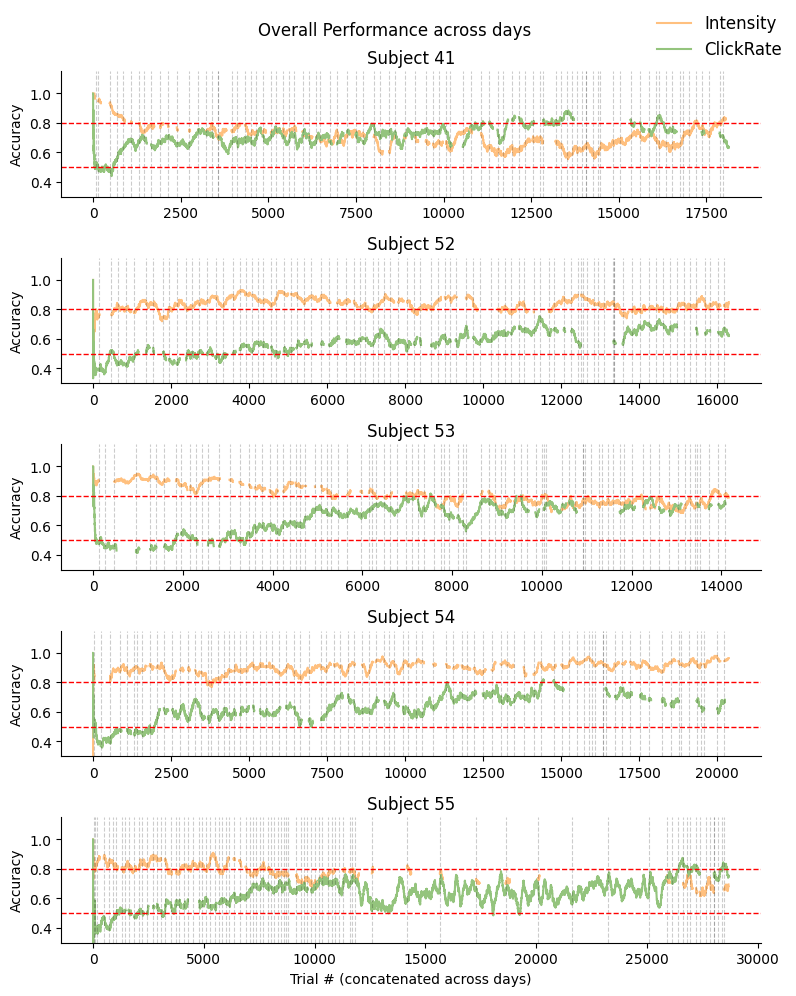

In [12]:
roll_size = 200
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_t1 = Task1_df.loc[Task1_df .subjects == subject].reset_index(drop=True)
    subject_data_t2 = Task2_df.loc[Task2_df .subjects == subject].reset_index(drop=True)

    subject_data_t1['roll_means'] = subject_data_t1.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_t2['roll_means'] = subject_data_t2.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date == day].reset_index(drop=True)
        sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_t1   = np.arange(offset, offset + len(sub_t1))
        x_t2 = np.arange(offset, offset + len(sub_t2))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_t1,   sub_t1.roll_means,   color=colors[0])
        axes[idx].plot(x_t2, sub_t2.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_t1), len(sub_t2))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Overall Performance across days')
fig.legend(
    [task1_label, task2_label],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

**Performance for Context-Invariant Stimuli**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_15297/2489554379.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


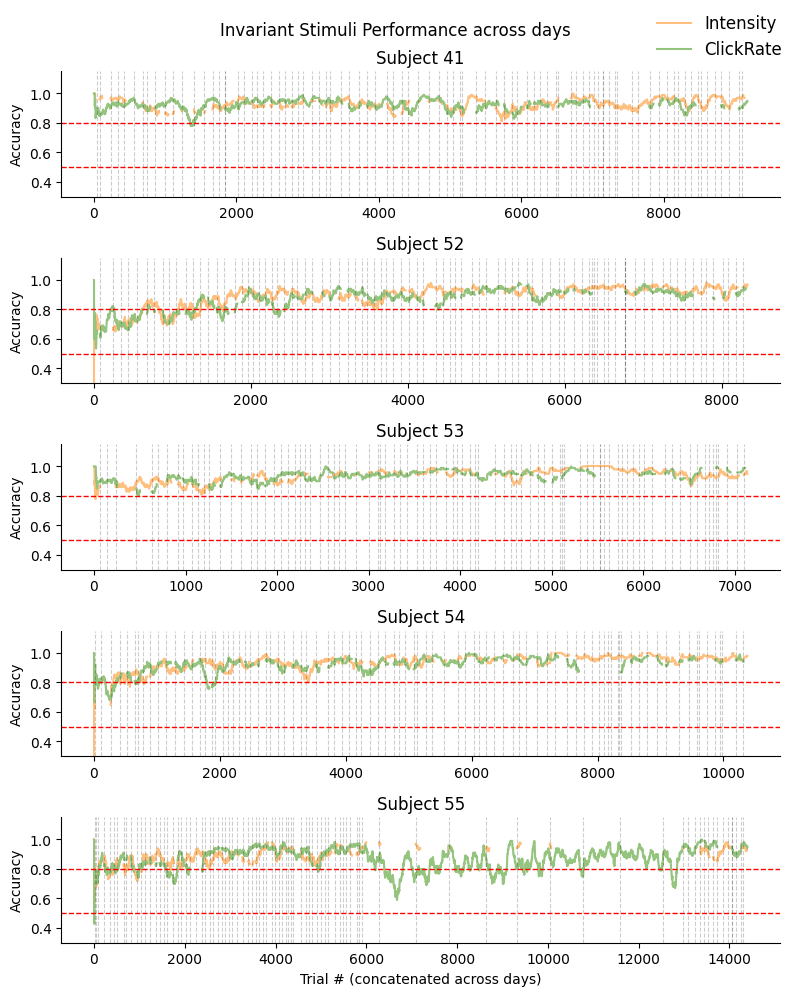

In [14]:
roll_size = 100
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_t1 = INVARIANT_TASK1.loc[INVARIANT_TASK1 .subjects == subject].reset_index(drop=True)
    subject_data_t2 = INVARIANT_TASK2.loc[INVARIANT_TASK2 .subjects == subject].reset_index(drop=True)

    subject_data_t1['roll_means'] = subject_data_t1.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_t2['roll_means'] = subject_data_t2.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date == day].reset_index(drop=True)
        sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_t1   = np.arange(offset, offset + len(sub_t1))
        x_t2 = np.arange(offset, offset + len(sub_t2))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_t1,   sub_t1.roll_means,   color=colors[0])
        axes[idx].plot(x_t2, sub_t2.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_t1), len(sub_t2))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Invariant Stimuli Performance across days')
fig.legend(
    [task1_label, task2_label],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

**Performance for Context-Dependent Stimuli**

/var/folders/nn/8m_833q103bgc9nrgbf5_d500000gn/T/ipykernel_15297/2847208357.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


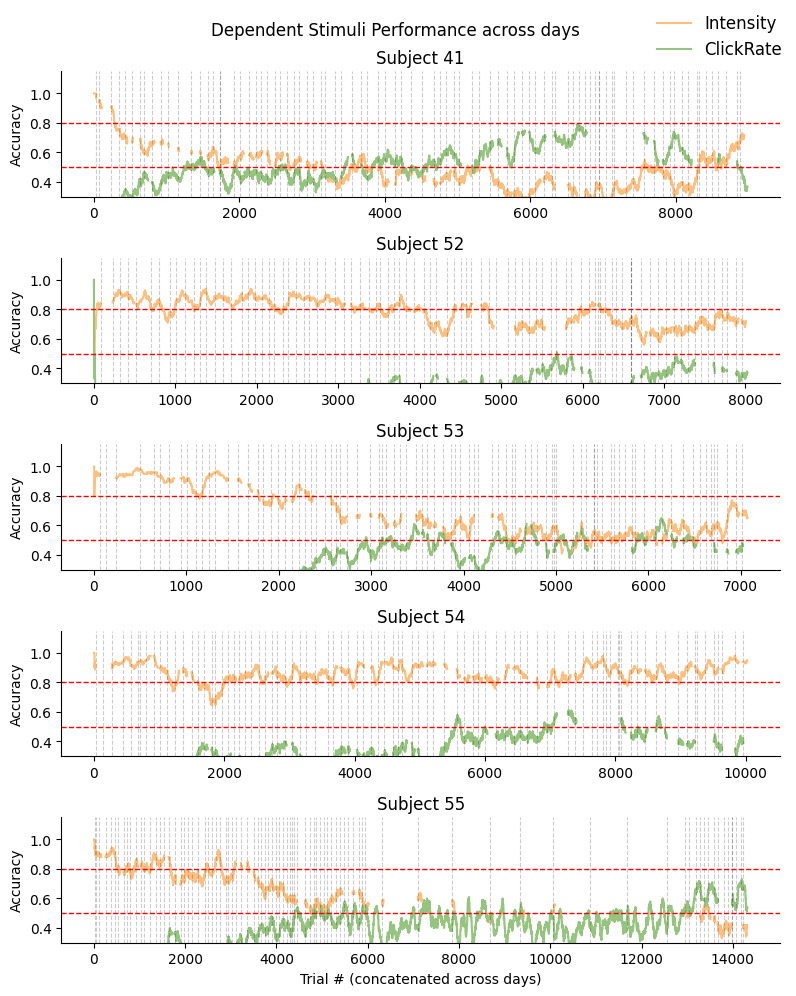

In [16]:
roll_size = 100
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(nrows = 5, ncols = 1, figsize=(8, 10), constrained_layout = True)

for idx, subject in enumerate(subject_IDs):
    offset = 0                               # how many trials have we already placed?
    boundaries = []                          # collect (x-pos, date) tuples for later

    subject_data_t1 = DEPENDENT_TASK1.loc[DEPENDENT_TASK1 .subjects == subject].reset_index(drop=True)
    subject_data_t2 = DEPENDENT_TASK2.loc[DEPENDENT_TASK2 .subjects == subject].reset_index(drop=True)

    subject_data_t1['roll_means'] = subject_data_t1.outcomes.rolling(roll_size, min_periods=1).mean()
    subject_data_t2['roll_means'] = subject_data_t2.outcomes.rolling(roll_size, min_periods=1).mean()

    for day in all_days:                     # ⬅  make sure this list is chronological
        # --- slice one day ------------------------------------------------------
        sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date == day].reset_index(drop=True)
        sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date == day].reset_index(drop=True)

        # x coordinates shifted by the cumulative offset
        x_t1   = np.arange(offset, offset + len(sub_t1))
        x_t2 = np.arange(offset, offset + len(sub_t2))

        # --- plot the two tasks -------------------------------------------------
        axes[idx].plot(x_t1,   sub_t1.roll_means,   color=colors[0])
        axes[idx].plot(x_t2, sub_t2.roll_means, color=colors[1])
        
        # --- prepare next loop --------------------------------------------------
        offset += max(len(sub_t1), len(sub_t2))     # where next day will start
        boundaries.append((offset, day))                # remember this end position

    # ---------------------------------------------------------------------------
    # Draw vertical lines and put the date right above each one
    y_top = axes[idx].get_ylim()[1]          # current upper y-limit
    for x_pos, day in boundaries[:-1]:    # skip final boundary (end of last day)
        axes[idx].axvline(x_pos, color='k', lw=0.8, alpha=0.2, linestyle = '--')

    axes[idx].axhline(0.8, color='red', ls='--', lw=1)
    axes[idx].axhline(0.5, color='red', ls='--', lw=1)

    axes[idx].set_ylim(0.3, 1.15)
    axes[idx].set_yticks(np.arange(0.4, 1.1, 0.2))

    if idx == len(subject_IDs)-1:
        axes[idx].set_xlabel('Trial # (concatenated across days)')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Subject {str(subject)[-2:]}')

    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

fig.suptitle('Dependent Stimuli Performance across days')
fig.legend(
    [task1_label, task2_label],
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    fontsize = 12,
    frameon = False
)
fig.tight_layout()
plt.show()

### Plot Mice Choice of a chosen day

In [17]:
day = all_days[-1]

**For all choices**

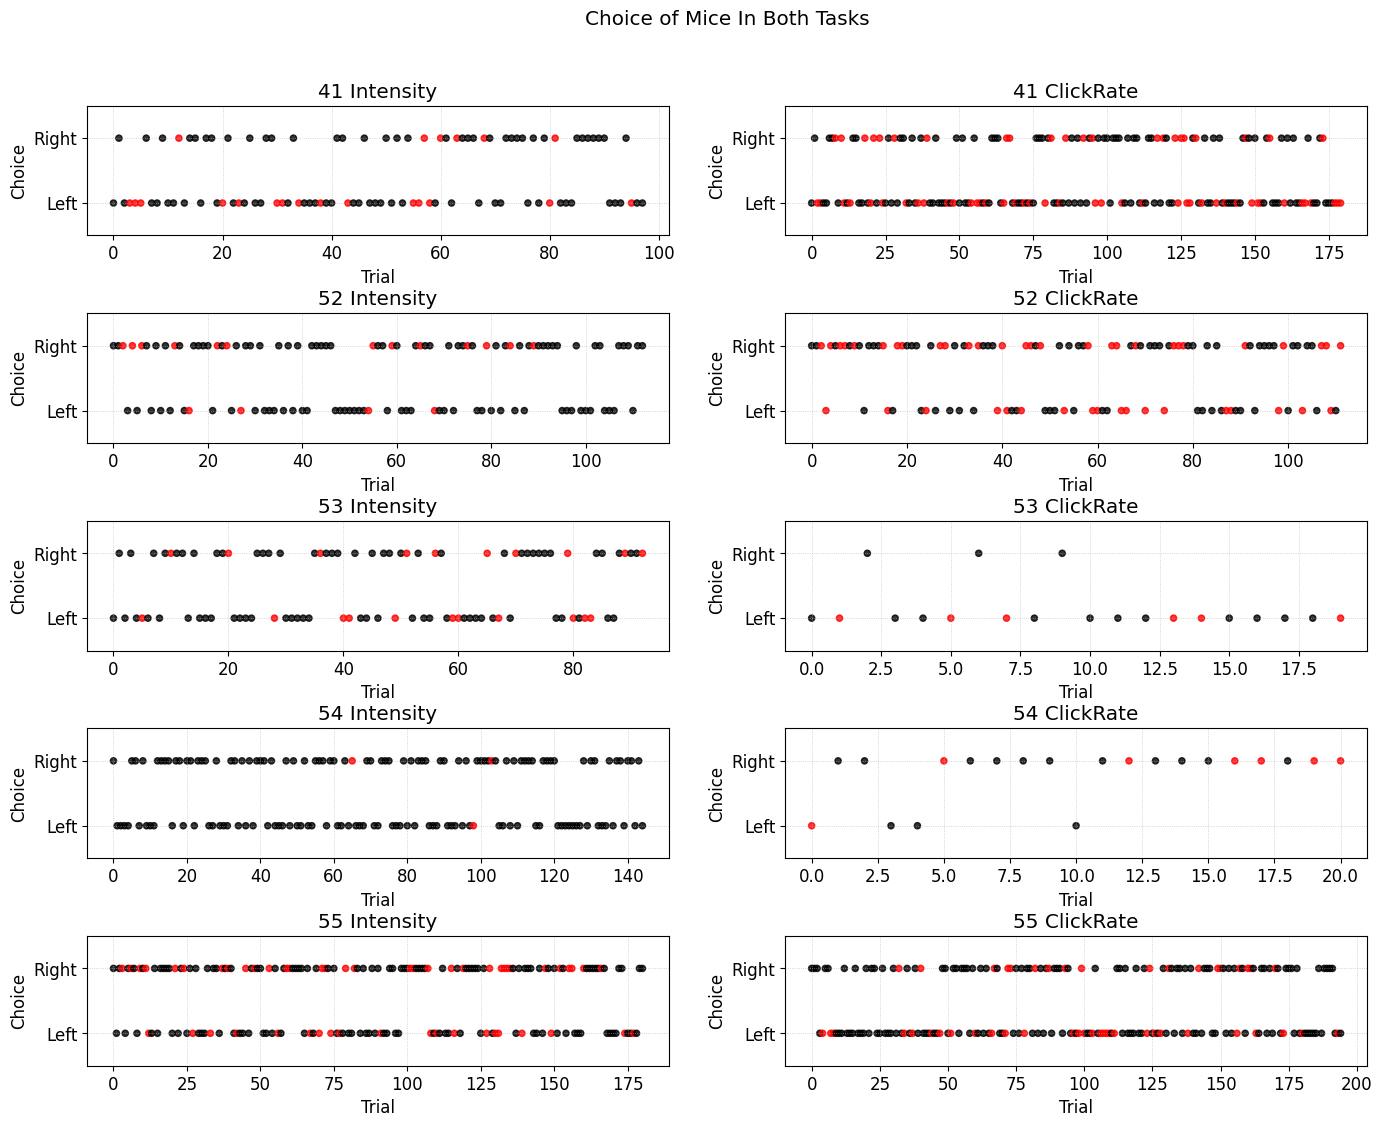

In [18]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_t1 = Task1_df.loc[Task1_df .subjects == subject].reset_index(drop=True)
    subject_data_t2 = Task2_df.loc[Task2_df .subjects == subject].reset_index(drop=True)
    
    sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date >= day].reset_index(drop=True)
    sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date >= day].reset_index(drop=True)

    # task1 first 
    x_t1 = sub_t1.get('trial', sub_t1.index)     # default: 0, 1, 2, …
    colors_t1 = np.where(sub_t1['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_t1,
            sub_t1['choices'],    
            c=colors_t1,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} {task1_label}')

    # task2
    x_t2 = sub_t2.get('trial', sub_t2.index)     # default: 0, 1, 2, …
    colors_t2 = np.where(sub_t2['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_t2,
            sub_t2['choices'],    
            c=colors_t2,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} {task2_label}')

plt.suptitle('Choice of Mice In Both Tasks')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


**Plot Choice separately for context-invariant stimuli**

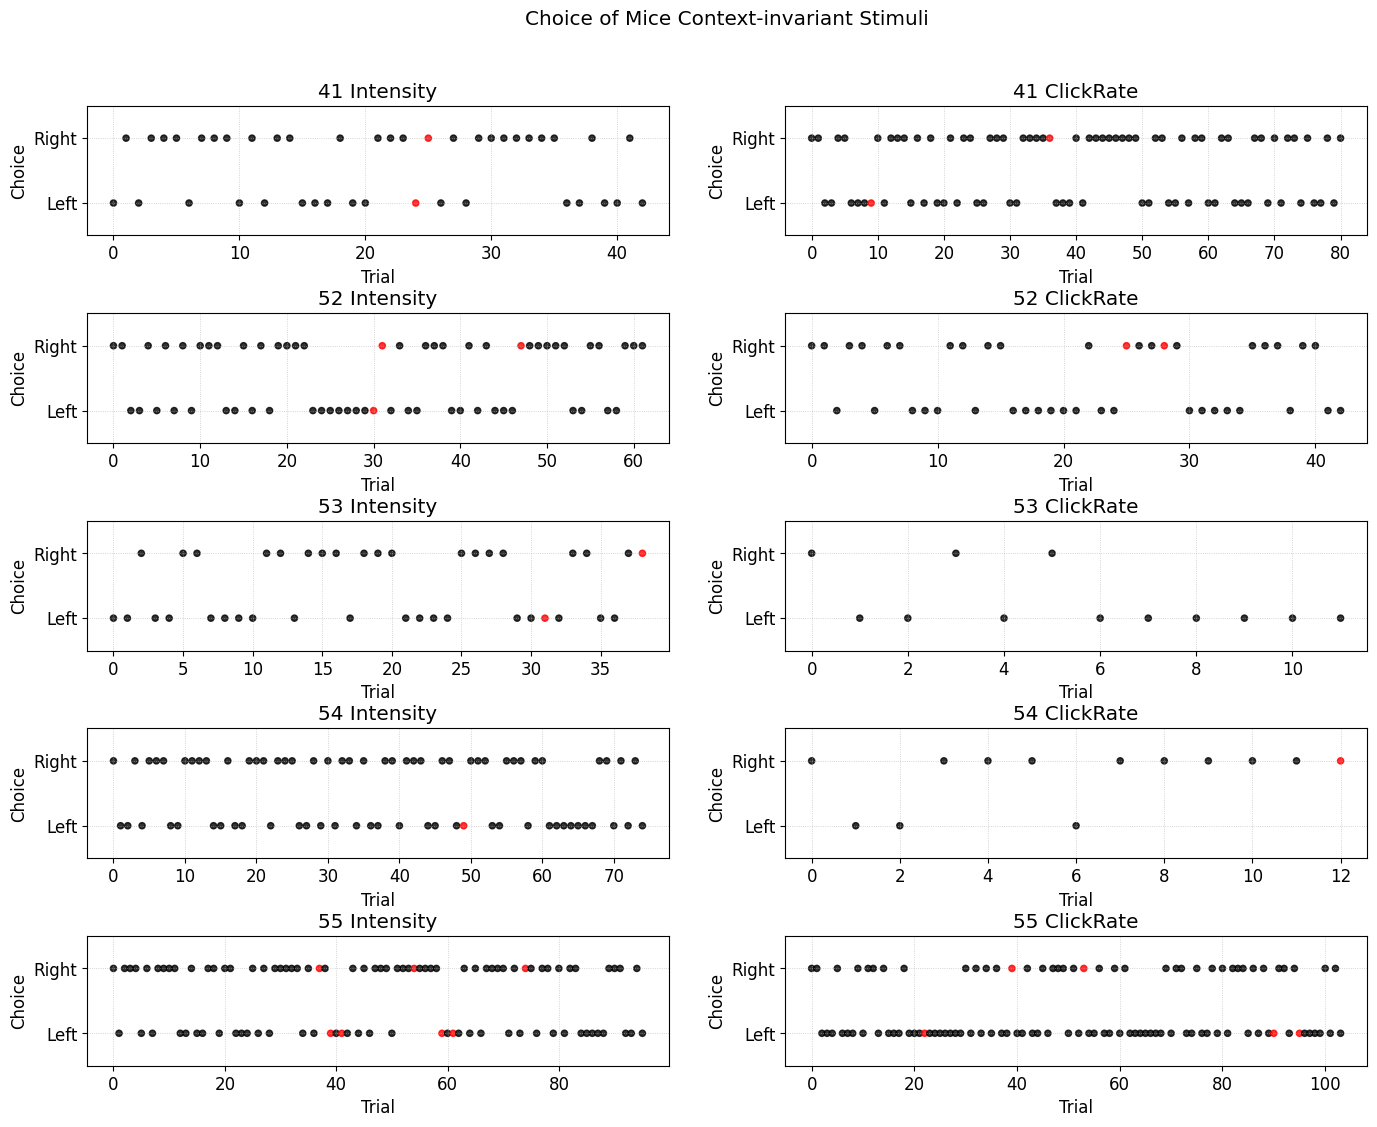

In [19]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_t1 = INVARIANT_TASK1.loc[INVARIANT_TASK1 .subjects == subject].reset_index(drop=True)
    subject_data_t2 = INVARIANT_TASK2.loc[INVARIANT_TASK2 .subjects == subject].reset_index(drop=True)
    
    sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date >= day].reset_index(drop=True)
    sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date >= day].reset_index(drop=True)

    # task 1 first 
    x_t1 = sub_t1.get('trial', sub_t1.index)     # default: 0, 1, 2, …
    colors_t1 = np.where(sub_t1['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_t1,
            sub_t1['choices'],    
            c=colors_t1,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} {task1_label}')

    # task 2
    x_t2 = sub_t2.get('trial', sub_t2.index)     # default: 0, 1, 2, …
    colors_t2 = np.where(sub_t2['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_t2,
            sub_t2['choices'],    
            c=colors_t2,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} {task2_label}')

plt.suptitle('Choice of Mice Context-invariant Stimuli')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


**Plot Choice separately for context-dependent stimuli**

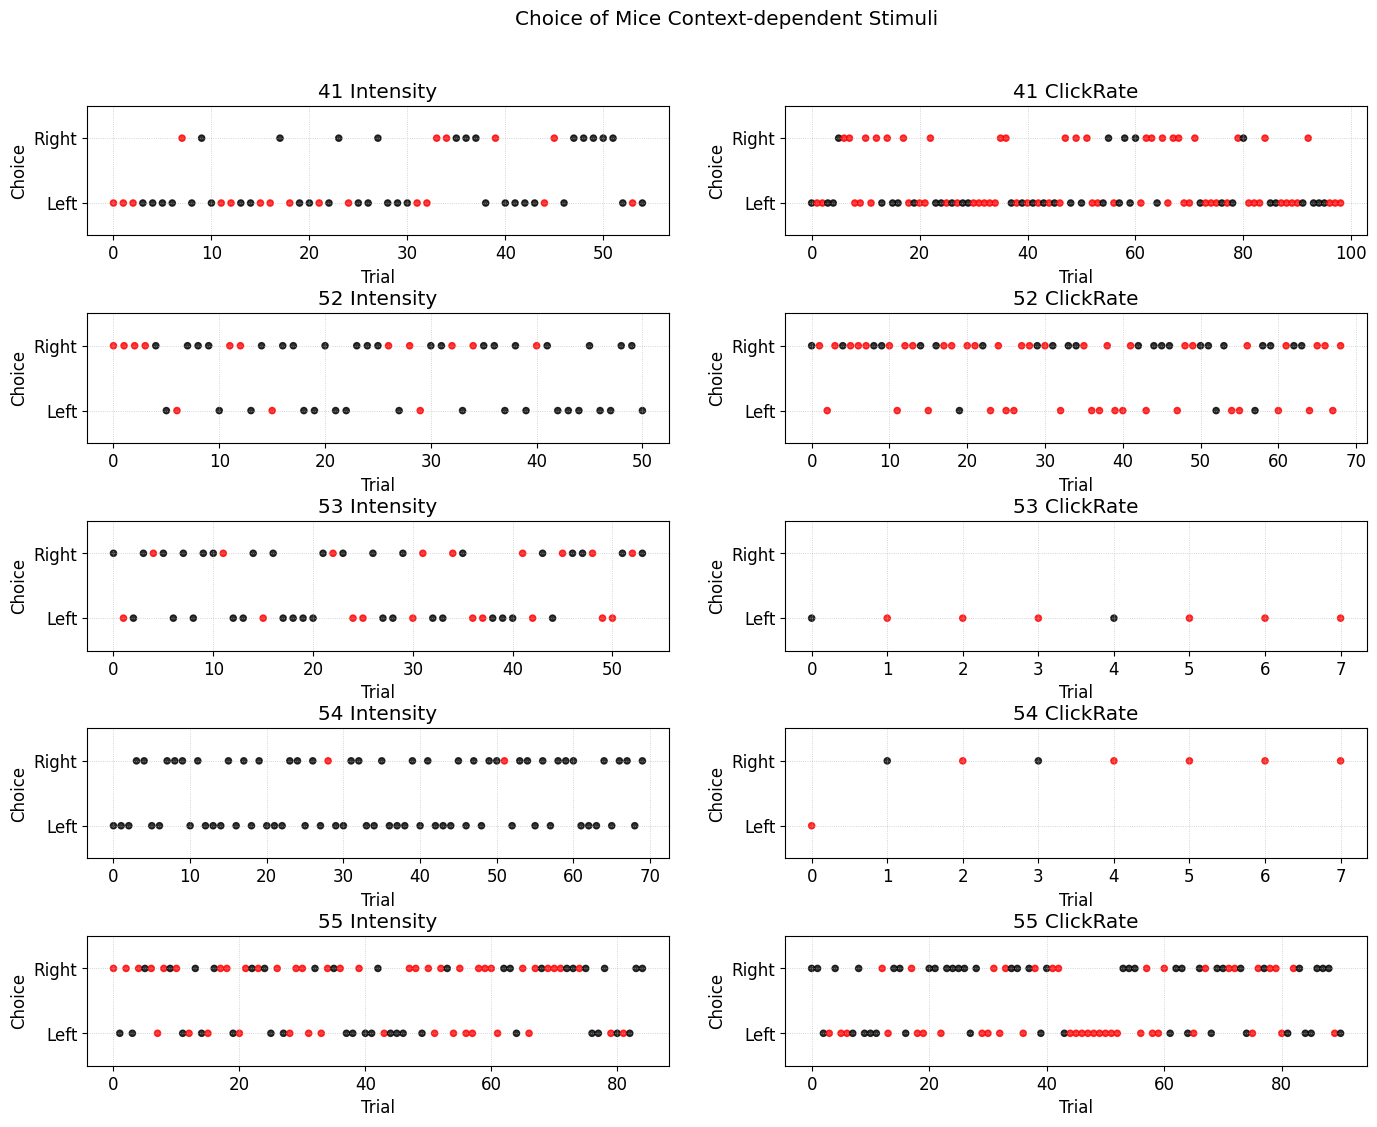

In [20]:
matplotlib.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 12))
for subject_id, subject in enumerate(subject_IDs):
    
    subject_data_t1 = DEPENDENT_TASK1.loc[DEPENDENT_TASK1 .subjects == subject].reset_index(drop=True)
    subject_data_t2 = DEPENDENT_TASK2.loc[DEPENDENT_TASK2 .subjects == subject].reset_index(drop=True)
    
    sub_t1  = subject_data_t1.loc[subject_data_t1.day.dt.date >= day].reset_index(drop=True)
    sub_t2 = subject_data_t2.loc[subject_data_t2.day.dt.date >= day].reset_index(drop=True)

    # task 1 first 
    x_t1 = sub_t1.get('trial', sub_t1.index)     # default: 0, 1, 2, …
    colors_t1 = np.where(sub_t1['outcomes'] == 1, 'black', 'red')      
    
    ax1 = plt.subplot(5, 2, subject_id * 2 + 1)                          
    ax1.scatter(x_t1,
            sub_t1['choices'],    
            c=colors_t1,
            s=20,
            alpha=0.8)

    ax1.set_yticks([23, 24])
    ax1.set_yticklabels(['Left', 'Right'])
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Choice') 
    ax1.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax1.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax1.set_title(f'{str(subject)[-2:]} {task1_label}')

    # task 2
    x_t2 = sub_t2.get('trial', sub_t2.index)     # default: 0, 1, 2, …
    colors_t2 = np.where(sub_t2['outcomes'] == 1, 'black', 'red')      
    ax2 = plt.subplot(5, 2, subject_id * 2 + 2)                          
    ax2.scatter(x_t2,
            sub_t2['choices'],    
            c=colors_t2,
            s=20,
            alpha=0.8)

    ax2.set_yticks([23, 24])
    ax2.set_yticklabels(['Left', 'Right'])
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('Choice') 
    ax2.set_ylim(22.5, 24.5)                  # add a little padding so dots aren’t on the frame
    ax2.grid(True, axis='both', linestyle=':', linewidth=0.6, alpha=0.7)
    ax2.set_title(f'{str(subject)[-2:]} {task2_label}')

plt.suptitle('Choice of Mice Context-dependent Stimuli')
plt.subplots_adjust(
    hspace=0.6,    # increase vertical padding between rows
    wspace=0.2,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)


### plot performance in both tasks separately for context-dependent and -invariant stimuli

**task 1 - Arena A**

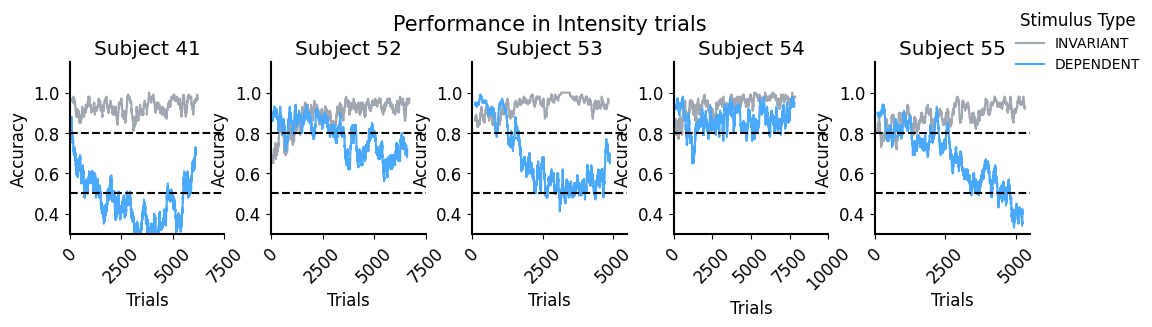

In [21]:
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
  
    sub_inv_t1 = INVARIANT_TASK1.loc[INVARIANT_TASK1.subjects == subject].reset_index(drop=True)
    sub_inv_t1.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
    sub_dep_t1 = DEPENDENT_TASK1.loc[DEPENDENT_TASK1.subjects == subject].reset_index(drop=True)
    sub_dep_t1.outcomes.rolling(roll_size).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='black', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_t1), len(sub_dep_t1))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle(f'Performance in {task1_label} trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10,
    frameon = False
)
plt.show()

**Task 2 - Arena B**

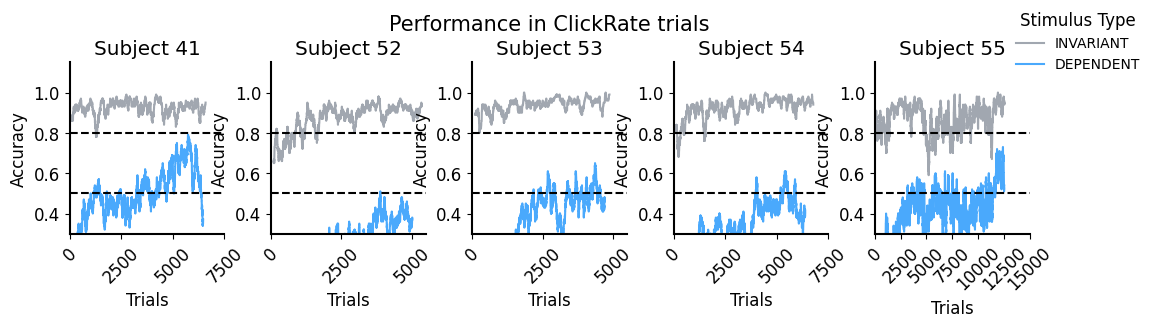

In [22]:
# # plot separately for context-dependent and -invariant stimuli in Task2_df trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    sub_inv_t2 = INVARIANT_TASK2.loc[INVARIANT_TASK2.subjects == subject].reset_index(drop=True)
    sub_inv_t2.outcomes.rolling(roll_size).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
    sub_dep_t2 = DEPENDENT_TASK2.loc[DEPENDENT_TASK2.subjects == subject].reset_index(drop=True)
    sub_dep_t2.outcomes.rolling(roll_size).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
    plt.title(f'Subject {str(subject)[-2:]}')
    idx += 1
    ax.axhline(0.8, color='black', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    x_max = max(len(sub_inv_t2), len(sub_dep_t2))
    if x_max < 5500:
        lim_x = 5500
    else:
        lim_x = math.ceil(x_max / 2500) * 2500
    ax.set_xlim(0, lim_x) 
    ax.set_xticks(np.arange(0, lim_x+1, 2500))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trials')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle(f'Performance in {task2_label} trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize=10,
    frameon = False
)
plt.show()

### Plot the swith frequency and initial performance

In [23]:
'''Helper functions'''
def process_block_data(subject_data):
    subject_data = subject_data.sort_values("times").reset_index(drop=True)
    subject_data["trial_idx"] = subject_data.index

    # (a) contiguous-block labels
    subject_data['block_id'] = subject_data['task'].ne(
        subject_data['task'].shift()
    ).cumsum()

    # (b) trial index *within* each block
    subject_data['within_block_idx'] = (
        subject_data
        .groupby('block_id')
        .cumcount()
    )

    # (c) block length for every trial 
    block_len = (
        subject_data.groupby('block_id')
        .size()
        .rename('block_len')
    )
    subject_data_block = subject_data.join(block_len, on='block_id')
    return subject_data_block

def process_day_data(subject_data):
    subject_data = subject_data.sort_values("times").reset_index(drop=True)
    subject_data["trial_idx"] = subject_data.index

    # (a) contiguous-block labels
    subject_data['day_id'] = subject_data['day'].ne(
        subject_data['day'].shift()
    ).cumsum()

    # (b) trial index *within* each day
    subject_data['within_day_idx'] = (
        subject_data
        .groupby('day_id')
        .cumcount()
    )

    # (c) daily trial length
    daily_trial_len = (
        subject_data.groupby('day_id')
        .size()
        .rename('daily_trial_len')
    )
    subject_data_day = subject_data.join(daily_trial_len, on='day_id')
    return subject_data_day

def boxplot_trial_per_session(subject_data_processed, subject, ax):
    block_len_df = (
        subject_data_processed[['task', 'block_id', 'block_len']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    t1_len = block_len_df.loc[block_len_df['task'] == 24, 'block_len']
    t2_len = block_len_df.loc[block_len_df['task'] == 29, 'block_len']
    data = [t1_len, t2_len]

    palette = {24: colors[0], 29: colors[1]} 

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.6,
        positions=[1.0, 1.75],
        boxprops    = dict(edgecolor='black',linewidth = 1.5),
        medianprops = dict(color='black', linewidth=1.5),
        whiskerprops= dict(color='black'),
        capprops    = dict(color='black')
    )

    box_colors = [palette[24], palette[29]]
    for box, col in zip(bp['boxes'], box_colors):
        box.set_facecolor(col)
        box.set_alpha(0.8) 

    rng      = np.random.default_rng(1)
    jitter   = 0
    dot_area = 55

    # task1 dots (blue)
    x24 = 1 + rng.uniform(-jitter, jitter, len(t1_len))
    ax.scatter(
        x24, t1_len,
        marker='o',
        s=dot_area,
        facecolors=palette[24],   # your blue
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )

    # task2 dots (orange)
    x29 = 1.75 + rng.uniform(-jitter, jitter, len(t2_len))
    ax.scatter(
        x29, t2_len,
        marker='o',
        s=dot_area,
        facecolors=palette[29],   # your orange
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )
    ax.set_title(f'Subject {str(subject)[-2:]}')
    # ax.set_ylim([-100,750])
    ax.set_xlim([0.5, 2.1])
    ax.set_xticklabels(['Arena A', 'Arena B'], fontsize = 8)
    ax.set_ylabel('# trials before switch')
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('figures/switch_frequency.pdf',bbox_inches='tight')
    # plt.show()
    return t1_len, t2_len
    
def trial_length_average_and_ttest(t1_len, t2_len):
    t_stat, p_val = stats.ttest_ind(t1_len, t2_len, equal_var=False)  # Welch’s t-test
    if p_val > 0.05:
        print(f'Subject stays in either arena does NOT significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    else:
        print(f'Subject stays in either arena DOES significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    t1_len_mean = np.mean(t1_len)
    t1_len_se = t1_len.std(ddof=1) / np.sqrt(len(t1_len))
    t2_len_mean = np.mean(t2_len)
    t2_len_se = t2_len.std(ddof=1) / np.sqrt(len(t2_len))
    print(f'{task1_label} task on average runs for {t1_len_mean} trials ± {t1_len_se:.2f}, the range is [{min(t1_len)},{max(t1_len)}]')
    print(f'{task2_label} task on average runs for {t2_len_mean} trials ± {t2_len_se:.2f}, the range is [{min(t2_len)},{max(t2_len)}]\n')

def plot_afterswitch_performance(subject_data, subject, ax, max_k = 20):
    palette = {24: colors[0], 29: colors[1]} 
    trimmed = subject_data[subject_data['within_block_idx'] < max_k].copy()

    summ = (
        trimmed
        .groupby(['task', 'within_block_idx'])['outcomes']
        .agg(mean='mean', count='count', std='std')
        .reset_index()
    )
    summ['sem'] = summ['std'] / np.sqrt(summ['count'])

    #smoothing
    for col in ['mean', 'sem']:
        summ[f'smooth_{col}'] = (
            summ
            .groupby('task')[col]
            .transform(lambda s: s.rolling(3,
                                            center=True,
                                            min_periods=1).mean())
        )

    for task_val in (24, 29):
        g  = summ[summ['task'] == task_val]
        x  = g['within_block_idx']
        m  = g['smooth_mean']
        se = g['smooth_sem']
        cur_label = 'Arena A' if task_val == 24 else 'Arena B'
        ax.plot(x, m, color=palette[task_val], label=cur_label)
        ax.fill_between(x, m - se, m + se,
                        color=palette[task_val], alpha=0.25)
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.set_xlim(-0.5, max_k - 0.5)
    ax.set_xlabel('Trials', fontsize = 9)
    ax.set_ylabel('Accuracy',fontsize = 9)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('figures/after_switch_accuray.pdf',bbox_inches='tight')
    # plt.show()

def barplot_trial_per_session(t1_len, t2_len, colors, subject, ax):
    face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
    face_B = mcolors.to_rgba(colors[1], 0.6)
    means = [t1_len.mean(),  t2_len.mean()]
    sems  = [t1_len.std(ddof=1) / np.sqrt(len(t1_len)),
            t2_len.std(ddof=1)      / np.sqrt(len(t2_len))]

    # bar centres match your old box positions
    xpos  = [0.2, 0.6]

    # --- bars ---
    ax.bar(xpos, means,
        yerr=sems,
        width=0.25,
        capsize=5,
        color=[face_A, face_B],
        edgecolor='black',
        linewidth=1)


    # --- axes styling ---
    # ax.set_ylim([0, 120])
    ax.set_xlim([0, 0.8])
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
    ax.set_ylabel('# trials before switch', fontsize = 10)
    # ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.rcParams["svg.fonttype"] = "none"

def barplot_trial_perday(subject_data_processed, colors, subject, ax):
    daily_len_df = (
        subject_data_processed
        .groupby(['day_id', 'task'])   # group by day *and* task
        .size()
        .reset_index(name='daily_trial_len')
    )

    t1_daily_len = daily_len_df.loc[daily_len_df['task'] == 24, 'daily_trial_len']
    t2_daily_len = daily_len_df.loc[daily_len_df['task'] == 29, 'daily_trial_len']

    face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
    face_B = mcolors.to_rgba(colors[1], 0.6)

    means = [t1_daily_len.mean(),  t2_daily_len.mean()]
    sems  = [t1_daily_len.std(ddof=1) / np.sqrt(len(t1_daily_len)),
            t2_daily_len.std(ddof=1)      / np.sqrt(len(t2_daily_len))]

    # bar centres match your old box positions
    xpos  = [0.2, 0.6]

    # --- bars ---
    ax.bar(xpos, means,
        yerr=sems,
        width=0.25,
        capsize=5,
        color=[face_A, face_B],
        edgecolor='black',
        linewidth=1)

    # --- axes styling ---
    ax.set_xlim([0, 0.8])
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
    ax.set_ylabel('# Trials per day', fontsize = 10)
    # ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.rcParams["svg.fonttype"] = "none"

def trials_to_plateau(block_df,
                      plateau_type='max',   # 'mean' | 'max'
                      roll_window=3,         # width of smoothing window (trials)
                      tol=0.02):             # how close is “close enough” (e.g. 0.02 = ±2 p.p.)
    """
    Return the FIRST trial index (1-based) at which a smoothed accuracy trace
    rises to within `tol` of the plateau value *and stays there*.
    
    Parameters
    ----------
    block_df : DataFrame
        One block (arena stay), must contain 'within_block_idx' (0-based) and 'outcomes' (0/1).
    plateau_type : {'mean', 'max'}
        • 'mean' → plateau = block mean accuracy  
        • 'max'  → plateau = max accuracy achieved in the block
    roll_window : int
        Rolling-mean window (in trials) used to smooth accuracy before thresholding.
    tol : float
        Allowed distance below the plateau value that still counts as “on plateau”.

    Returns
    -------
    int | np.nan
        Trial number where plateau is first reached, or NaN if never reached.
    """
    # chronological order
    g = block_df.sort_values('within_block_idx')
    
    # smoothed running performance (centered rolling mean)
    smooth = (g['outcomes']
              .rolling(roll_window, center=True, min_periods=1)
              .mean())
    
    # plateau value
    if plateau_type == 'mean':
        plateau_val = g['outcomes'].mean()
    elif plateau_type == 'max':
        plateau_val = g['outcomes'].max()
    else:
        raise ValueError("plateau_type must be 'mean' or 'max'")
    
    # threshold for “good enough”
    thresh = plateau_val - tol
    
    # first trial where smoothed perf ≥ thresh
    reached = np.flatnonzero(smooth >= thresh)
    if reached.size == 0:
        return np.nan
    
    # +1 so that Trial 0 (index) → Trial 1 (human-readable)
    return int(g.iloc[reached[0]]['within_block_idx'] + 1)

def calculate_trials_to_plateau(subject_data_block, max_k = 20, mode = "mean"):
    # trimmed = subject_data_block[subject_data_block['within_block_idx'] < max_k]
    trimmed = subject_data_block
    # list of dicts → DataFrame
    records = []
    for (task, block_id), block_df in trimmed.groupby(['task', 'block_id']):
        ttp = trials_to_plateau(block_df,
                                plateau_type=mode,  # or 'max'
                                roll_window=10,
                                tol=0.02)
        records.append({'task': task,
                        'block_id': block_id,
                        'trials_to_plateau': ttp})

    ttp_df = pd.DataFrame(records).dropna()

    stats = (ttp_df
            .groupby('task')['trials_to_plateau']
            .agg(mean='mean',  # bar height
                count='count',
                std='std')
            .assign(sem=lambda d: d['std'] / np.sqrt(d['count'])))
    return stats

def plot_trials_to_plateau(block_stats, subject, ax):
    face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
    face_B = mcolors.to_rgba(colors[1], 0.6)
    bar_colors = [face_A,face_B]   # reuse your palette

    x = [0.2,0.6]
    ax.bar(x,
        height=block_stats['mean'],
        yerr=block_stats['sem'],
        color=bar_colors,
        edgecolor='black',
        width=0.25,
        capsize=3)

    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.set_xlim([0, 0.9])
    ax.set_xticks(x)
    ax.set_xticklabels(['Arena A', 'Arena B'],fontsize = 9)
    ax.set_ylabel('# trials to plateau',fontsize = 10)

    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()

def barplot_session_perday(subject_data, colors, subject, ax):
    session_df = (subject_data
                     .groupby(['day', 'task'])['block_id']
                     .nunique()
                     .reset_index()
                     .rename(columns={'block_id': 'n_sessions'}))
    t1_session_len = session_df.loc[session_df['task'] == 24, 'n_sessions']
    t2_session_len = session_df.loc[session_df['task'] == 29, 'n_sessions']
    
    face_A = mcolors.to_rgba(colors[0], 0.6)   # 0.4 = 40 % opaque
    face_B = mcolors.to_rgba(colors[1], 0.6)

    means = [t1_session_len.mean(),  t2_session_len.mean()]
    sems  = [t1_session_len.std(ddof=1) / np.sqrt(len(t1_session_len)),
            t2_session_len.std(ddof=1)      / np.sqrt(len(t2_session_len))]

    # bar centres match your old box positions
    xpos  = [0.2, 0.6]
    # --- bars ---
    ax.bar(xpos, means,
        yerr=sems,
        width=0.25,
        capsize=5,
        color=[face_A, face_B],
        edgecolor='black',
        linewidth=1)


    # --- axes styling ---
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.set_xlim([0, 0.9])
    ax.set_xticks(xpos, ['Arena A', 'Arena B'], fontsize=9)
    ax.set_ylabel('# Sessions per day', fontsize = 10)
    # ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.rcParams["svg.fonttype"] = "none"


Subject stays in either arena does NOT significantly differ: t = -0.352,  p = 0.7255
Intensity task on average runs for 87.39716312056737 trials ± 12.81, the range is [2,1547]
ClickRate task on average runs for 92.56737588652483 trials ± 7.23, the range is [1,532]

Subject stays in either arena does NOT significantly differ: t = 1.646,  p = 0.1010
Intensity task on average runs for 87.5657894736842 trials ± 9.46, the range is [5,1028]
ClickRate task on average runs for 68.32236842105263 trials ± 6.87, the range is [2,577]

Subject stays in either arena does NOT significantly differ: t = 0.092,  p = 0.9265
Intensity task on average runs for 83.1880341880342 trials ± 11.11, the range is [2,1084]
ClickRate task on average runs for 81.92307692307692 trials ± 8.01, the range is [1,476]

Subject stays in either arena does NOT significantly differ: t = 1.108,  p = 0.2690
Intensity task on average runs for 106.38775510204081 trials ± 12.45, the range is [4,1511]
ClickRate task on average runs 

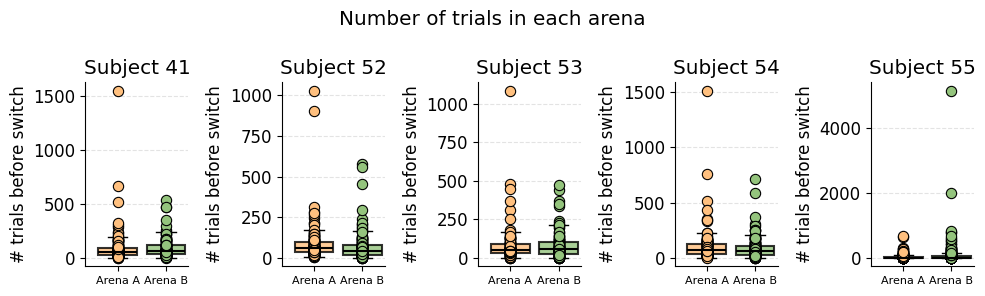

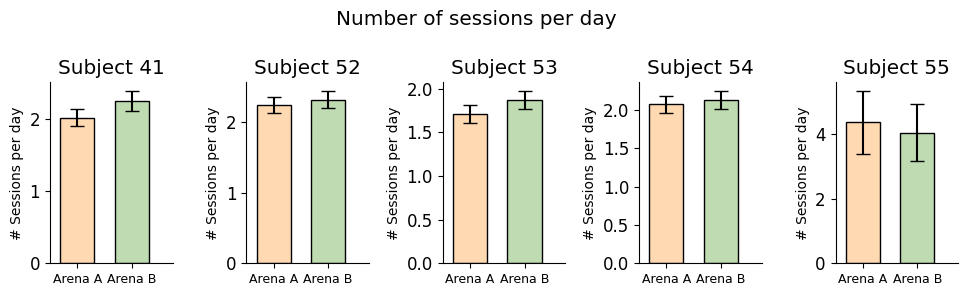

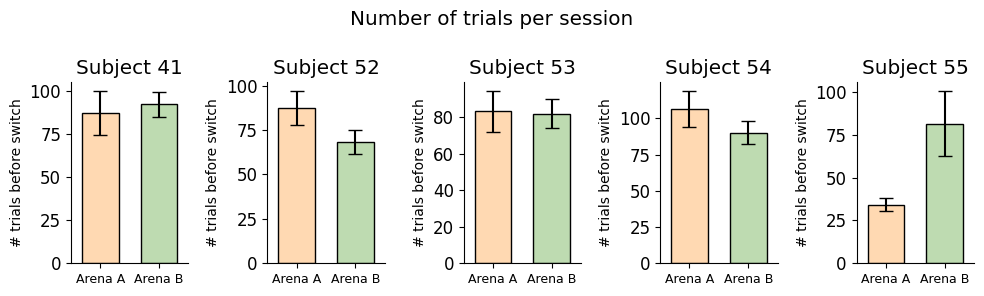

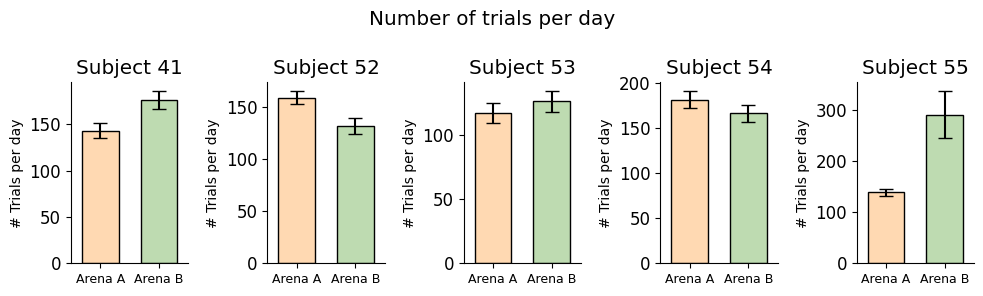

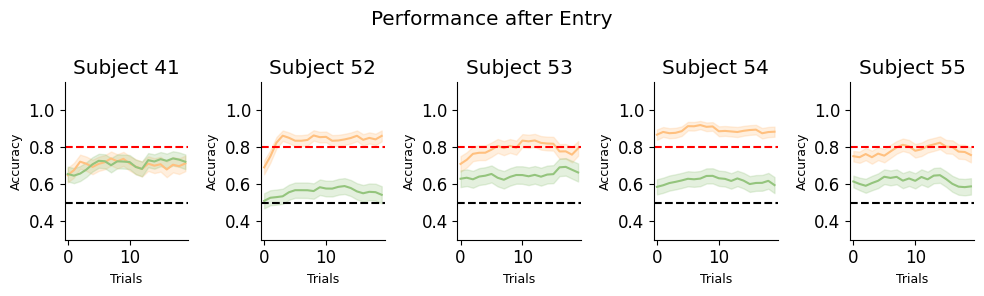

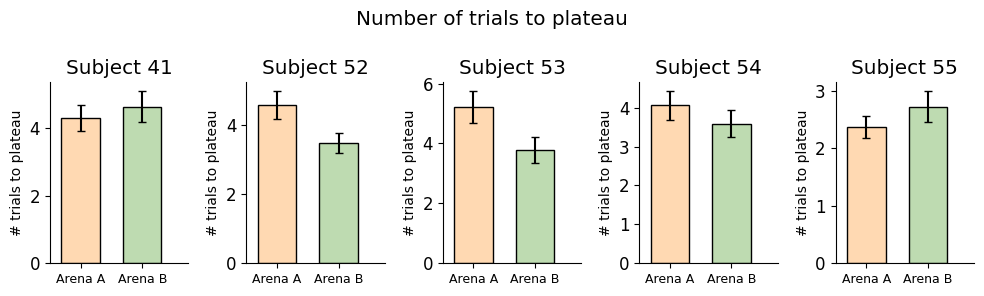

In [26]:
fig1, axgrid1 = plt.subplots(1, 5, figsize=(10, 3))   # box-plots
fig2, axgrid2 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves
fig3, axgrid3 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves
fig4, axgrid4 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves
fig5, axgrid5 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves
fig6, axgrid6 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves

matplotlib.rcParams['font.size'] = 12
for idx, subject in enumerate(subject_IDs):
    # row, col = divmod(idx, 5)
    
    ax1 = axgrid1[idx]      
    ax2 = axgrid2[idx] 
    ax3 = axgrid3[idx] 
    ax4 = axgrid4[idx] 
    ax5 = axgrid5[idx] 
    ax6 = axgrid6[idx] 

    subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
    # add block feature 
    subject_data_block = process_block_data(subject_data)

    '''Number of trials in each session (before switch)'''
    # box plot to show number of trials per session (# trials before switch)
    t1_len, t2_len = boxplot_trial_per_session(subject_data_block, subject, ax1)
    # bar plot to show number of trials per session (# trials before switch)
    barplot_session_perday(subject_data_block, colors, subject, ax2)
    # ttest to see if mice have any preference of staying in either arena
    trial_length_average_and_ttest(t1_len, t2_len)

    '''Performance immediately after switch'''
    # plot the max_k performance right after switch 
    plot_afterswitch_performance(subject_data_block, subject, ax5, max_k = 20)
    block_stats = calculate_trials_to_plateau(subject_data_block, mode = "mean")
    # plot how many trials animals take to reach the mean/max performance of that session
    plot_trials_to_plateau(block_stats, subject, ax6)
    
    barplot_trial_per_session(t1_len, t2_len, colors, subject, ax3)
    subject_data_day = process_day_data(subject_data)
    barplot_trial_perday(subject_data_day, colors, subject, ax4)
    
fig1.suptitle('Number of trials in each arena')
fig1.tight_layout()

fig2.suptitle('Number of sessions per day')
fig2.tight_layout()

fig3.suptitle('Number of trials per session')
fig3.tight_layout()

fig4.suptitle('Number of trials per day')
fig4.tight_layout()

fig5.suptitle('Performance after Entry')
fig5.tight_layout()

fig6.suptitle('Number of trials to plateau')
fig6.tight_layout()

plt.show()